# Model to predict graph embedding from paths

## TQDM dark mode

In [1]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>


# Load data

In [10]:
import pickle
from pathlib import Path
with open(Path('F:\\') / 'data' / 'prov_dp' / 'tc3-trace-training.pkl', 'rb') as f:
    data_unflattened = pickle.load(f)

In [11]:
from itertools import chain
dataset = list(chain.from_iterable(data_unflattened))

len(dataset)

1489123

## Model Parameters

In [12]:
import torch

embedding_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Generate tokens

In [15]:
tokens = set()
distinct_paths = set()

def tokenize(path):
    assert len(path) % 2 == 0
    return [f'{path[idx]}|{path[idx+1]}' for idx in range(0, len(path), 2)]

for path, _ in dataset:
    path = tokenize(path.split(' '))
    tokens.update(path)
    distinct_paths.add(' '.join(path))
tokens = list(tokens)
tokens[:0] = ['.']
itos = tokens
stoi = {
    token: i for i, token in enumerate(itos)
}

print(f'Found {len(tokens)} tokens in {len(dataset)} entries')
print(f'Distinct paths: {len(distinct_paths)}')

Found 16 tokens in 1489123 entries
Distinct paths: 37


In [14]:
[p[len('.|EPHEMERAL_EPHEMERAL .|EPHEMERAL_EPHEMERAL'):] for p in distinct_paths]

[' PROCESS_LET_xfsettingsd|PROC_CREATE_Start_Processlet',
 ' PROCESS_LET_xfce4-appfinder|PROC_CREATE_Start_Processlet PROCESS_LET_xfce4-appfinder|PROC_CREATE_Start_Processlet PROCESS_LET_firefox|PROC_CREATE_Start_Processlet PROCESS_LET_firefox|PROC_CREATE_Start_Processlet PROCESS_LET_firefox|PROC_CREATE_Start_Processlet',
 ' PROCESS_LET_/usr/lib/thunderbird/thunderbird|PROC_CREATE_Start_Processlet',
 ' PROCESS_LET_run-parts|PROC_CREATE_Start_Processlet',
 '',
 ' PROCESS_LET_/usr/local/firefox-54.0.1/obj-x86_64-pc-linux-gnu/dist/bin/firefox|PROC_CREATE_Start_Processlet',
 ' PROCESS_LET_sh|PROC_CREATE_Start_Processlet PROCESS_LET_/usr/bin/env|PROC_CREATE_Start_Processlet',
 ' PROCESS_LET_firefox|PROC_CREATE_Start_Processlet PROCESS_LET_firefox|PROC_CREATE_Start_Processlet',
 ' PROCESS_LET_/usr/lib/x86_64-linux-gnu/xfce4/exo-1/exo-helper-1|PROC_CREATE_Start_Processlet PROCESS_LET_/usr/lib/x86_64-linux-gnu/xfce4/exo-1/exo-helper-1|PROC_CREATE_Start_Processlet PROCESS_LET_/bin/sh|PROC_CREAT

## Embed Graphs
graph embeddings don't make sense, why not just predict a discrete value if we're not embedding the path too?

In [ ]:
from tqdm.auto import tqdm
from source.algorithm.utility import to_nx

nx_graphs = [
    to_nx(graph)
    for _, graph in tqdm(dataset, desc='Converting to NetworkX graphs')
]
len(nx_graphs)

c:\Users\Jonathan\workspace\prov-dp\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Converting to NetworkX graphs: 100%|██████████| 1489123/1489123 [00:23<00:00, 63455.25it/s] 


1489123

In [ ]:
import numpy as np
lens = [len(g) for p, g in dataset]
print(f'Min: {min(lens)}, Max: {max(lens)}')
print(f'Avg: {np.average(lens)}, Std: {np.std(lens)}')


Min: 1, Max: 8
Avg: 1.0003753887355176, Std: 0.03720074179980315


In [40]:
context_length = 8
## Format training data
X, Y = [], []

def format_path(path: str) -> list[int]:
    path_list = tokenize(path_str.split(' '))
    # Convert into list of integers
    path = [stoi[s] for s in path_list]
    # Pad the sequence and right align it
    # TODO: this probably doesn't matter since the context never shifts, right?
    context = [0] * context_length
    for i in range(min(len(path), context_length)):
        context[-i-1] = path[i]
    return 


for i, row in enumerate(dataset):
    # Tokenize the path
    path_str, _ = row
    path = format_path(path_str)

    X.append(context)    
    Y.append(i)

X = torch.tensor(X, device=device)
Y = torch.tensor(Y, device=device)
print(X.shape, Y.shape)

torch.Size([1489123, 8]) torch.Size([1489123])


In [37]:
import torch.nn as nn
import torch.optim as optim

vocab_size = len(tokens)
n_embedding = 10 # Embedding dimension
n_hidden = 100
learning_rate = 0.01
batch_size = 32768
context_length = 8

# Predict the discrete graph to append
# Problem: Doesn't have the context of graph size
def create_model(): 
    return nn.Sequential(
        nn.Embedding(vocab_size, n_embedding),
        nn.Flatten(),
        nn.Linear(n_embedding * context_length, n_embedding * context_length), nn.ReLU(),
        nn.Linear(n_embedding * context_length, n_hidden), nn.ReLU(),
        nn.Linear(n_hidden, n_embedding)
    )
model = create_model()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
lossi = []

In [38]:
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm

max_steps = 100000
for i in range(max_steps):
    optimizer.zero_grad()

    ix = torch.randint(0, Y.shape[0], (batch_size,))
    X_batch, Y_batch = X[ix], Y[ix]

    # Forward pass
    output = model(X_batch) # output layer
    # print(embedding)
    # print(Y_batch)
    loss = F.cross_entropy(output, Y_batch)
    # print(loss)

    # Backward pass
    for p in model.parameters():
        p.requires_grad = True
    loss.backward()
    
    # update
    # clip_grad_norm(model.parameters(), max_norm=1.0)
    optimizer.step()

    # Track stats
    if i % 5000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.7f}')
    lossi.append(loss.log10().item())
    # break
    

      0/ 100000: 2.2776988
   5000/ 100000: 0.0005070
  10000/ 100000: 0.0005009
  15000/ 100000: 0.0005555
  20000/ 100000: 0.0001078
  25000/ 100000: 0.0000856
  30000/ 100000: 0.0000270
  35000/ 100000: 0.0000273
  40000/ 100000: 0.0000398
  45000/ 100000: 0.0000171
  50000/ 100000: 0.0000153
  55000/ 100000: 0.0003403
  60000/ 100000: 0.0000149
  65000/ 100000: 0.0000085
  70000/ 100000: 0.0000369
  75000/ 100000: 0.0000061
  80000/ 100000: 0.0000098
  85000/ 100000: 0.0000156
  90000/ 100000: 0.0000085
  95000/ 100000: 0.0000147


In [1]:
len(model.parameters())

NameError: name 'model' is not defined

In [49]:
model_path = Path('F:\\') / 'data' / 'prov_dp' / 'tc3-trace.tar'
torch.save(model.state_dict(), model_path)

# Predict from the model

In [ ]:
Model

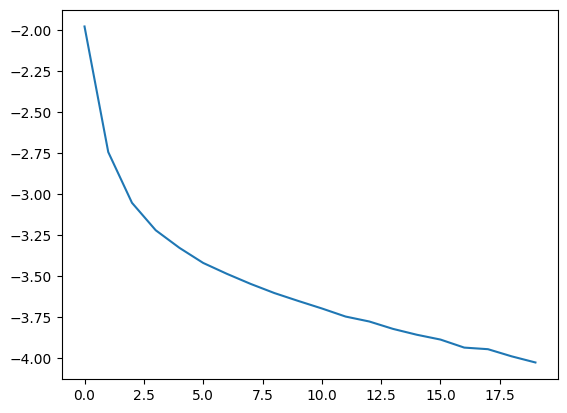

In [36]:
i = 0
path_str, graph = dataset[i]
path = format_path(path_str)

In [35]:
%pip install matplotlib

     ---------------------------------------- 0.0/162.2 kB ? eta -:--:--
     -------------------------------------- 162.2/162.2 kB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   -------- ------------------------------- 1.5/7.6 MB 49.2 MB/s eta 0:00:01
   ------------------- -------------------- 3.7/7.6 MB 47.7 MB/s eta 0:00:01
   ------------------------------ --------- 5.9/7.6 MB 47.2 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 44.4 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 44.4 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 32.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/186.7 kB ? eta -:--:--
   --------------------------------------- 186.7/186.7 kB 11.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------------- ---------- 1.6/2.2 MB 49.3 MB/s eta 0:00:01
   ----------------